In [126]:
## dataset
#import tensorflow.keras as keras
## for Model definition/training
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

## for visualizing 
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

import random
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from numpy.random import RandomState
from itertools import chain
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import scale

from collections import Counter
from mord import LogisticAT
import math
from matplotlib.offsetbox import AnchoredText
from os import listdir
import sys
sys.path.append('functions.py')

In [127]:
%run functions.py
x_16s, map_16s= get16sData(filt = False)
x_mtg,  map_mtg = getMtgData(filt = False)
x_mtt, map_mtt = getMttData(filt = False)
x_mbx, map_mbx = getMetabolData()
x_mbx_filt = filterForProkaryotes(x_mbx)

x_16s = x_16s.groupby(map_16s.host_name).mean()
x_mtg = x_mtg.groupby(map_mtg.host_name).mean()
x_mtt = x_mtt.groupby(map_mtt.host_name).mean()
x_mbx = x_mbx.groupby(map_mbx.host_name).mean()
x_mbx_filt = x_mbx_filt.groupby(map_mbx.host_name).mean()
samples_keep = combineOmics(x_16s, x_mtg, x_mtt, x_mbx)

x_16s = x_16s.loc[samples_keep, :]
x_mtg = x_mtg.loc[samples_keep, :]
x_mtt = x_mtt.loc[samples_keep, :]
x_mbx = x_mbx.loc[samples_keep, :]
x_mbx_filt = x_mbx_filt.loc[samples_keep, :]
all_omics = pd.concat([x_16s, x_mtg, x_mtt, x_mbx], axis = 1)

map_16s = formatMapping(map_16s, samples_keep)
map_mtg = formatMapping(map_mtg, samples_keep)
map_mtt = formatMapping(map_mtt, samples_keep)
map_mbx = formatMapping(map_mbx, samples_keep)


(453, 5265)
(177, 56)


In [128]:
#Encode data
encoded_16s = encodeBetweenOmics(data = x_16s, omic = "16s_metabol/", file = "0.1_False_manhattan_True", dim = '25')
encoded_mtg = encodeBetweenOmics(data = x_mtg, omic = "mtg_metabol/", file = "0.8_True_manhattan_True", dim = '25')
encoded_mtt = encodeBetweenOmics(data = x_mtt, omic = "mtt_metabol/", file = "0.8_False_euclidean_True", dim = '25')
all_omics_encoded = pd.concat([encoded_16s, encoded_mtg, encoded_mtt, x_mbx_filt], axis = 1)

weights/16s_metabol//direct_filter/prev_filt0.1/layer2/manhattan/
weights/mtg_metabol//direct_filter/prev_filt0.8/layer2/manhattan/
weights/mtt_metabol//direct_filter/prev_filt0.8/layer2/euclidean/


In [129]:
#all values should be 1
train_bool, test_bool = splitDatasets(x_16s, map_16s, return_bool= True, state = 1)
def checkMatch(data1, data2):
    print(np.sum([i == j for i,j in zip(data1.index.values, data2.index.values)]) / data1.shape[0])
    
checkMatch(x_16s, map_16s)
checkMatch(x_mtg, map_mtg)
checkMatch(x_mtt, map_mtt)
checkMatch(encoded_16s, map_16s)
checkMatch(encoded_mtg, map_mtg)
checkMatch(encoded_mtt, map_mtt)

1.0
1.0
1.0
1.0
1.0
1.0


In [130]:
def dropLowStd(data):
    return(data.loc[:, np.std(data, axis = 0) > 0])

def normalize(data):
    return((data - np.mean(data, axis = 0)) / (np.var(data, axis = 0)))

def logTransform(data):
    return(np.log(data + 1))

In [131]:
%run ml_functions.py
%run functions.py
data_storage = Storage([x_16s, x_mtg, x_mtt, x_mbx, all_omics])
encoded_storage = Storage([encoded_16s, encoded_mtg, encoded_mtt, x_mbx_filt, all_omics_encoded])
mapping_storage = Storage([map_16s, map_mtg, map_mtt, map_mtt, map_mtt])
data_storage.applyFunction(dropLowStd)
encoded_storage.applyFunction(dropLowStd)
data_storage.applyFunction(scale)
encoded_storage.applyFunction(scale)
train_bool, test_bool = splitDatasets(x_16s, map_16s, return_bool= True, state = 1)


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\sklearn\preprocess

In [132]:
tmp = pd.DataFrame()

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


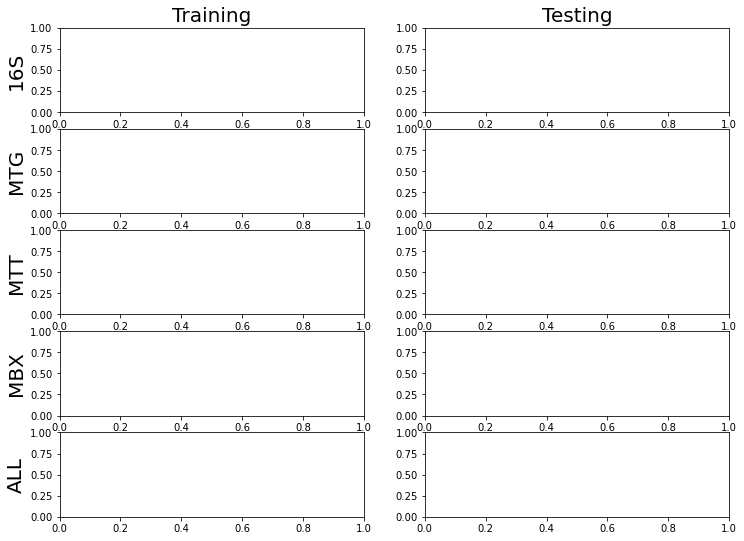

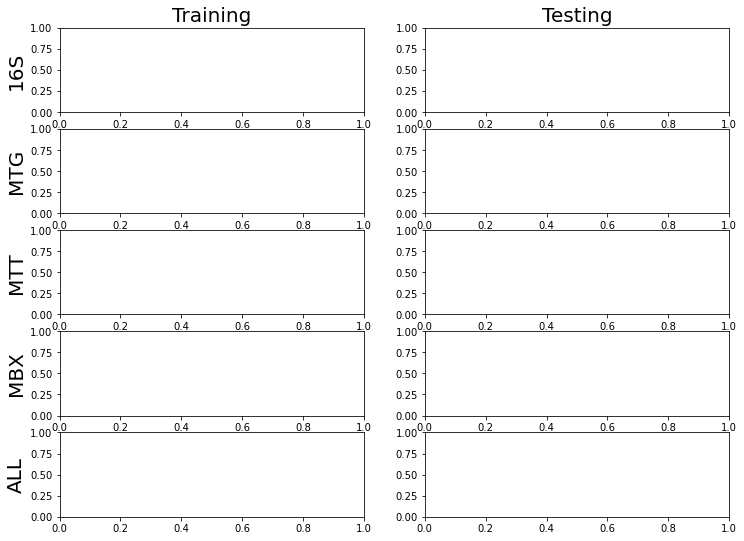

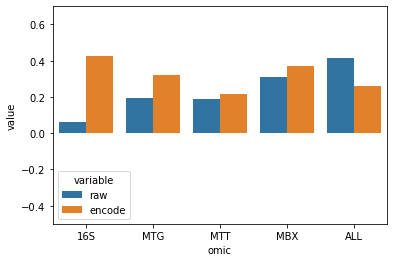

In [133]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              "fruit", 'rf', transformOrdinal_fruit)
tmp['fruit'] = res_raw +  res_encode
tmp.index = ['raw_16S', 'raw_MTG', 'raw_MTT', 'raw_MBX', 'raw_ALL',
                    '16S_MBX', 'MTG_MBX', 'MTT_MBX', 'MBX_filt', 'ALL_MBX']

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


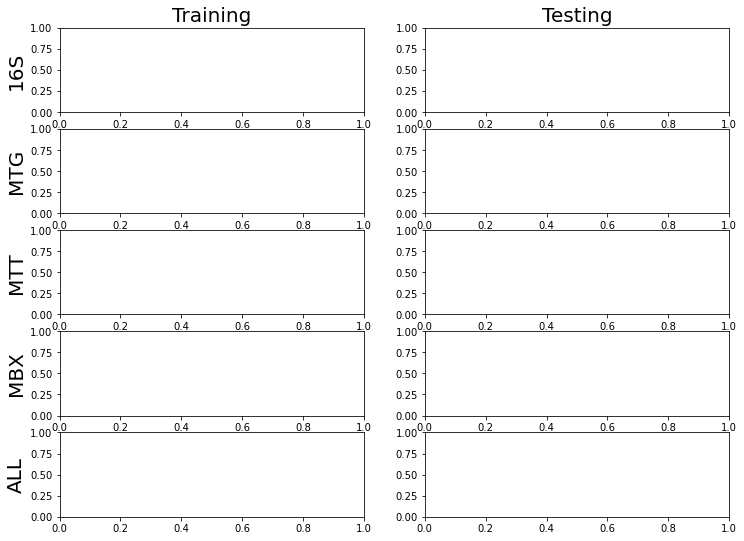

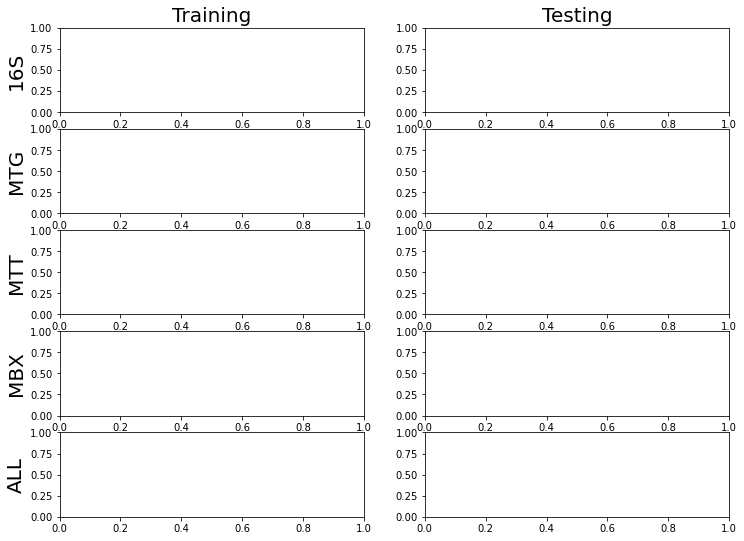

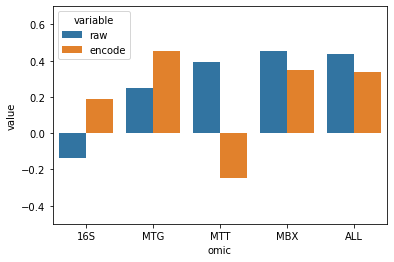

In [134]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              "dairy", 'rf', transform = transformOrdinal_fruit)
tmp['dairy'] = res_raw +  res_encode

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


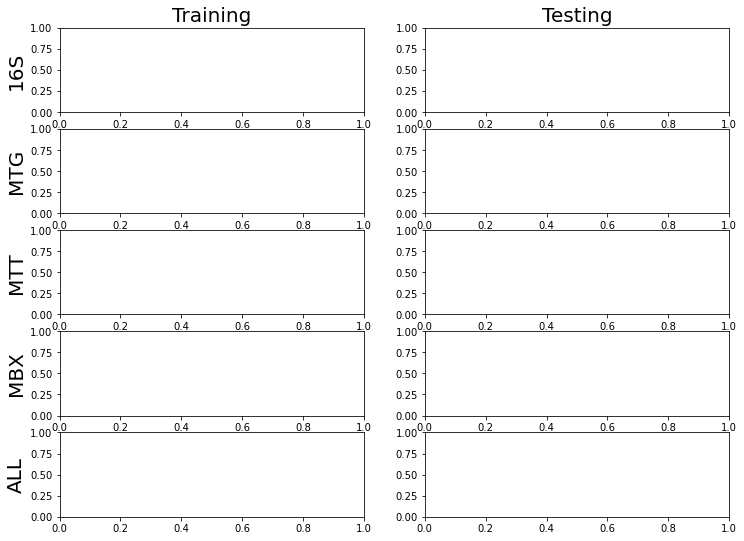

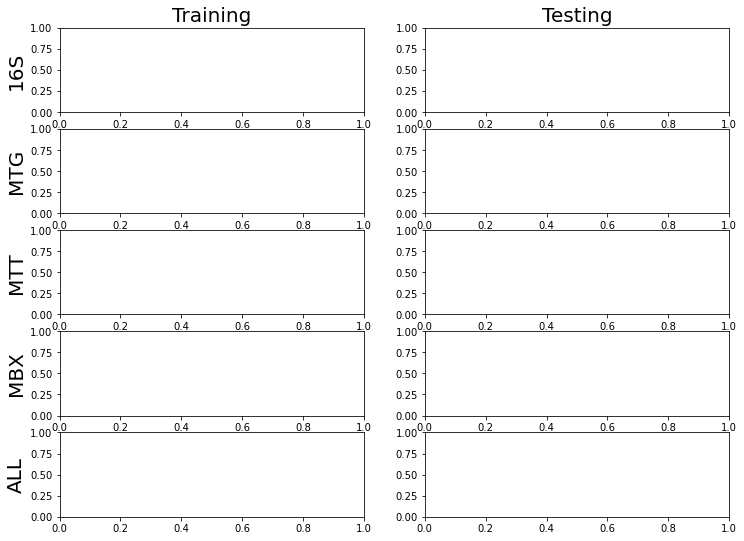

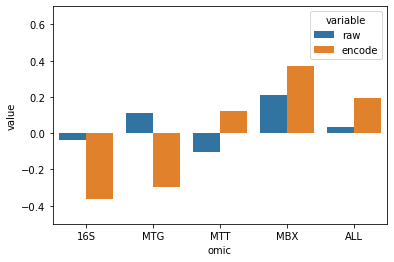

In [135]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'multivitamin', 'rf', transform = None)
tmp['multivitamin'] = res_raw +  res_encode

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


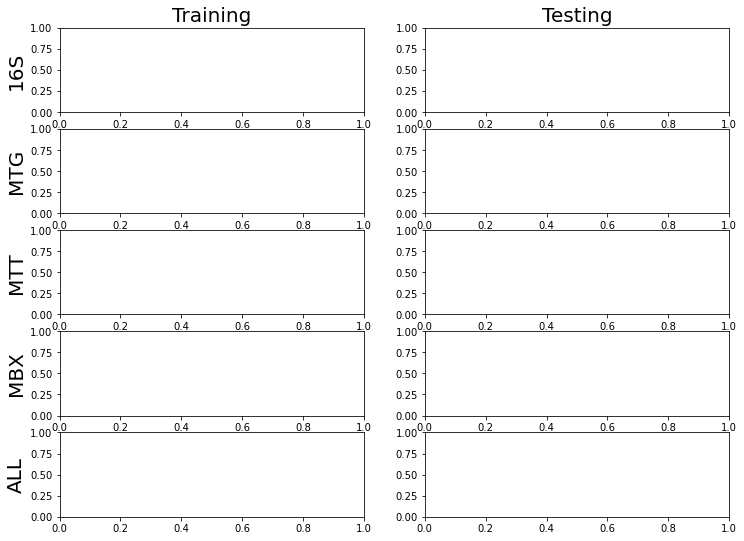

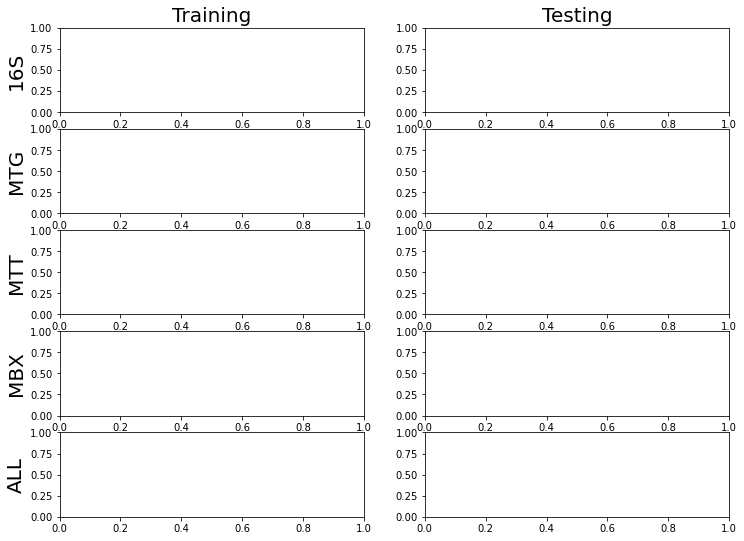

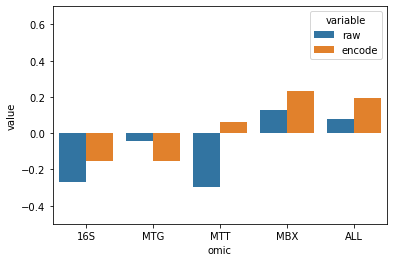

In [136]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'olive_oil', 'rf', transform = transformOrdinal_fruit)
tmp['olive_oil'] = res_raw +  res_encode

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


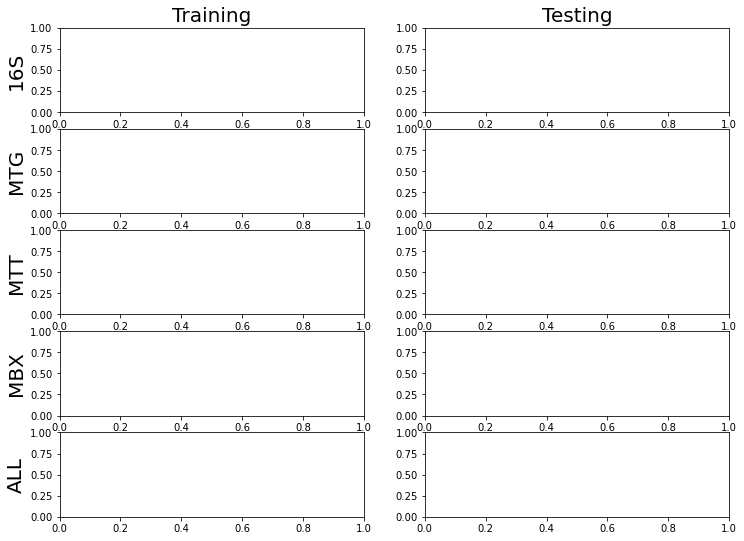

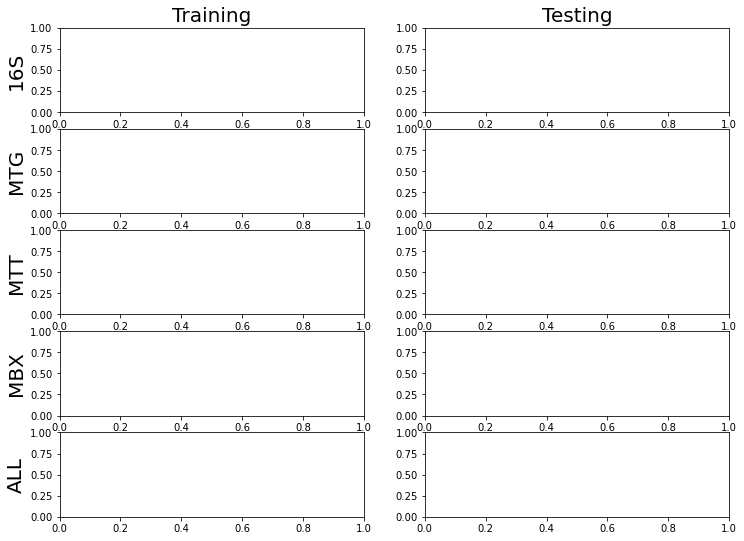

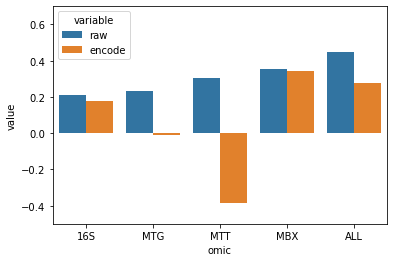

In [137]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'vegetable', 'rf', transform = transformOrdinal_fruit)
tmp['vegetable'] = res_raw +  res_encode

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


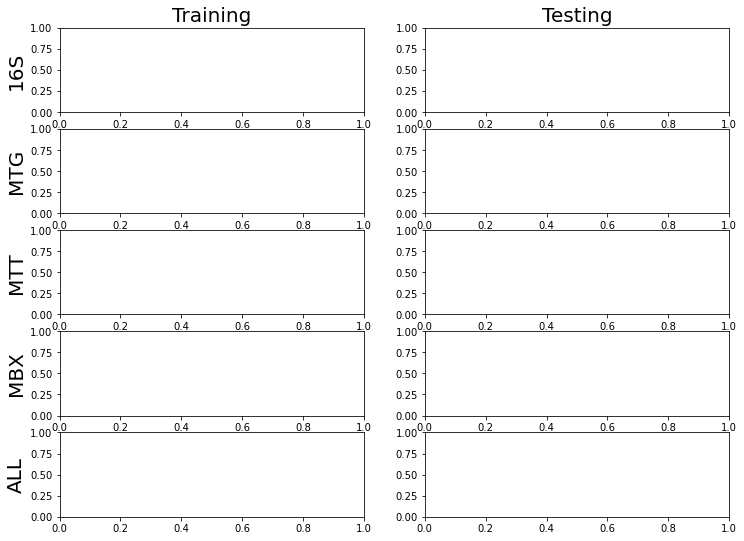

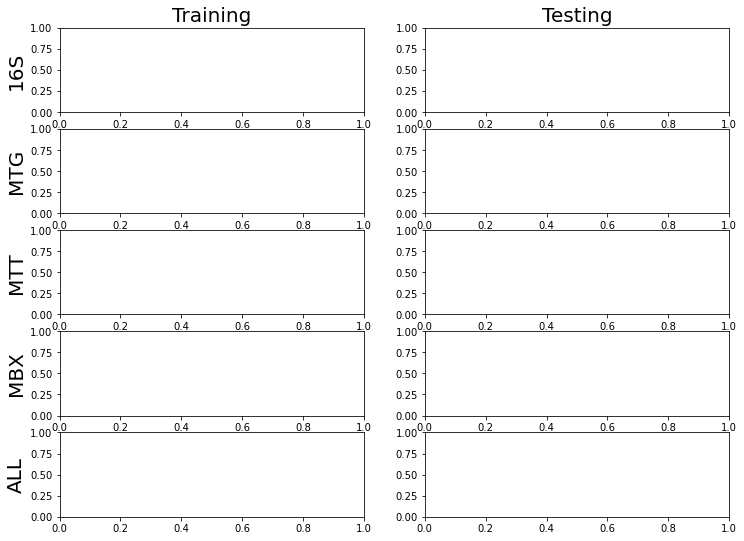

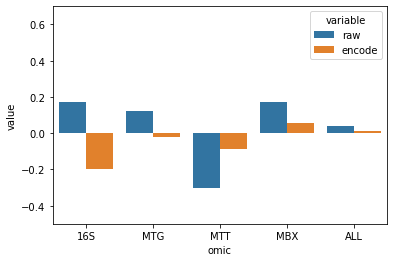

In [138]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'probiotic', 'rf', transform = transformOrdinal_fruit)
tmp['probiotic'] = res_raw +  res_encode

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


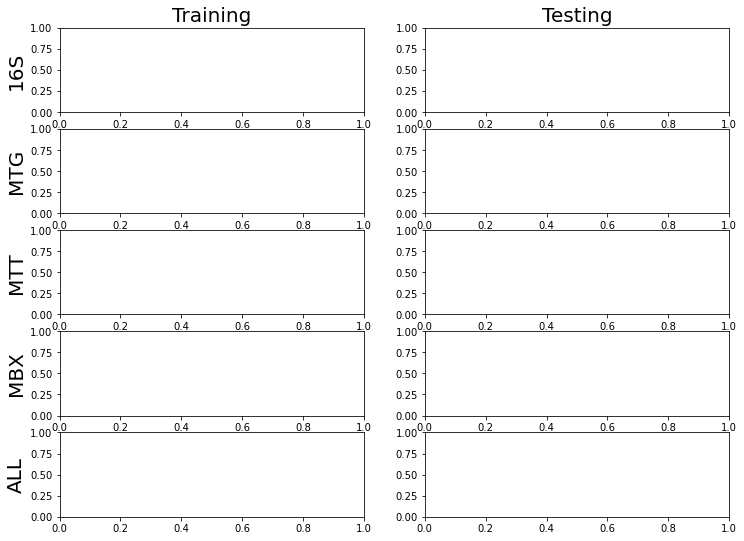

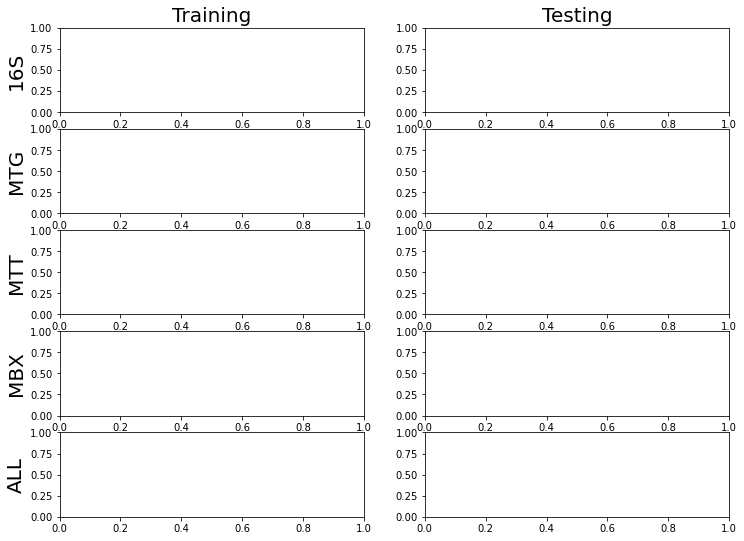

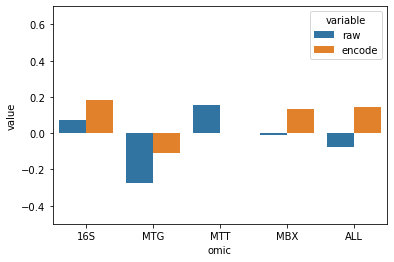

In [139]:
for i in np.arange(len(mapping_storage.getList())):
    mapping_storage.getList()[i].phenotype = [True if i == 'A' else False for i in mapping_storage.getList()[i].phenotype]
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'phenotype', 'rf', transform = None)
tmp['phenotype'] = res_raw +  res_encode

In [141]:
tmp.to_csv("performance_between_omics.csv")

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


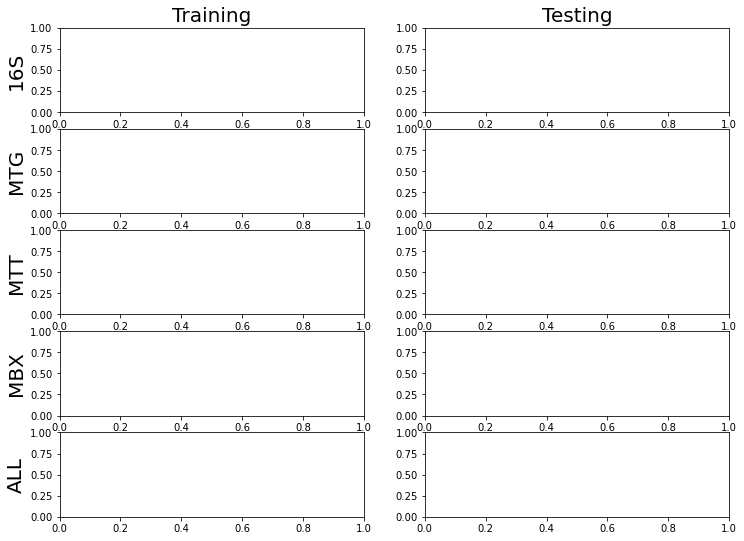

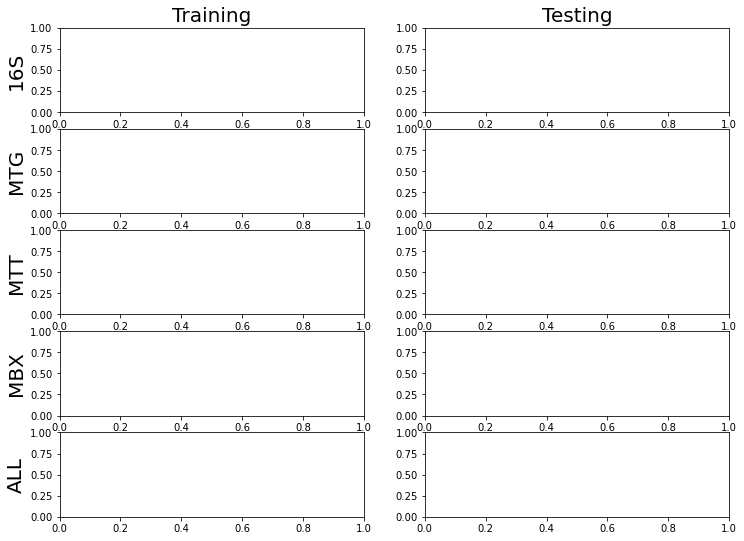

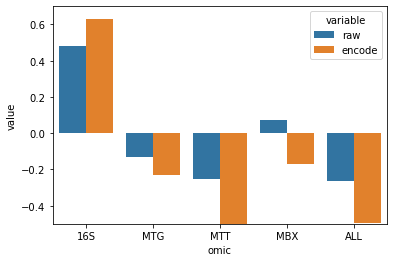

In [142]:
criteria = "vegetable_freq"
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              criteria, 'rf', transform = transformOrdinal_fruit)
tmp[criteria] = res_raw +  res_encode

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


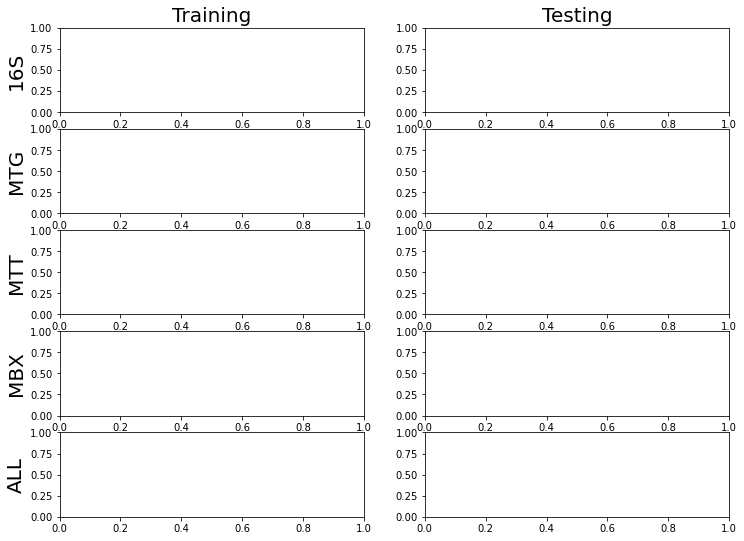

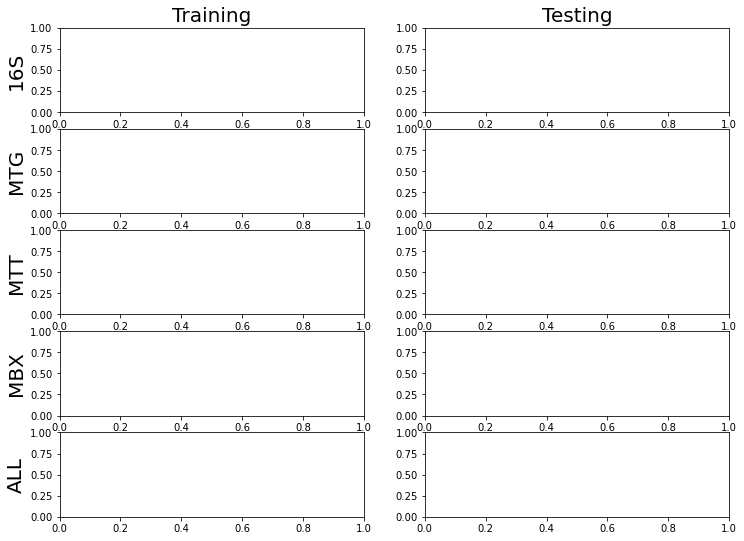

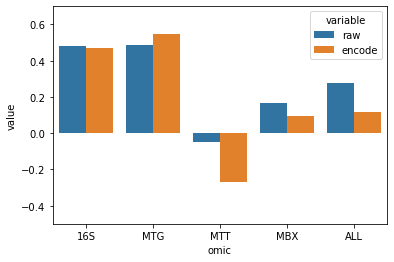

In [143]:
criteria = "fruit_freq"
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              criteria, 'rf', transform = transformOrdinal_fruit)
tmp[criteria] = res_raw +  res_encode

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


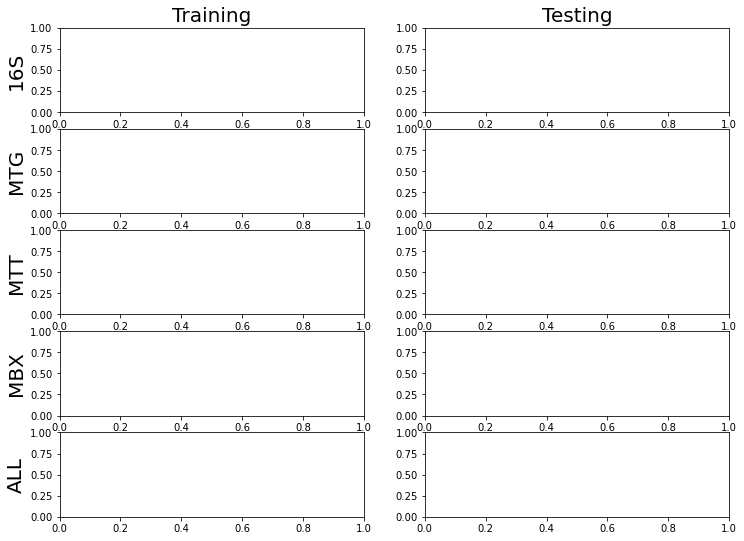

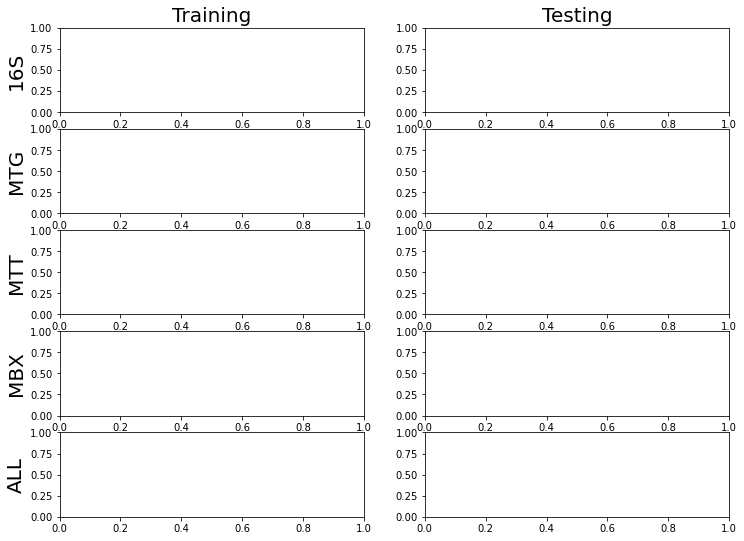

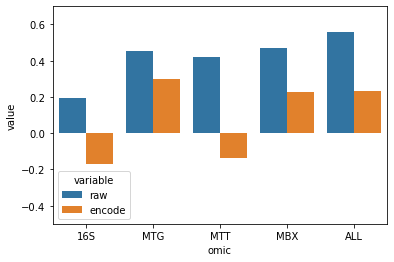

In [144]:
criteria = "dairy_freq"
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              criteria, 'rf', transform = transformOrdinal_fruit)
tmp[criteria] = res_raw +  res_encode

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


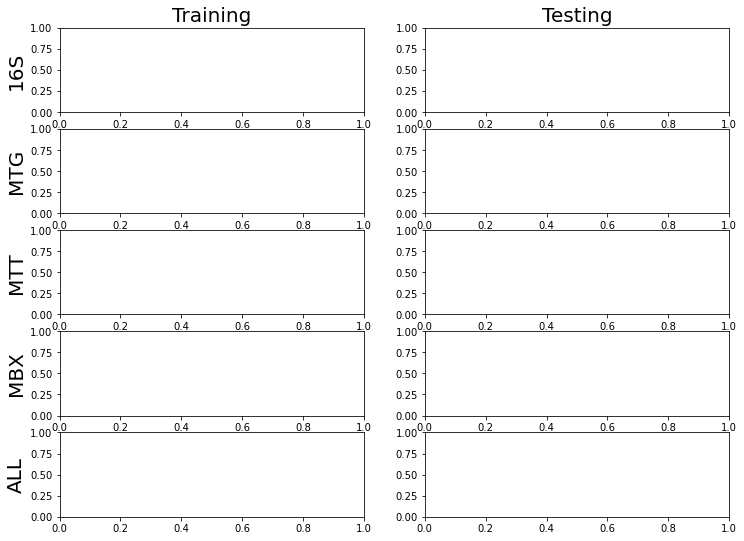

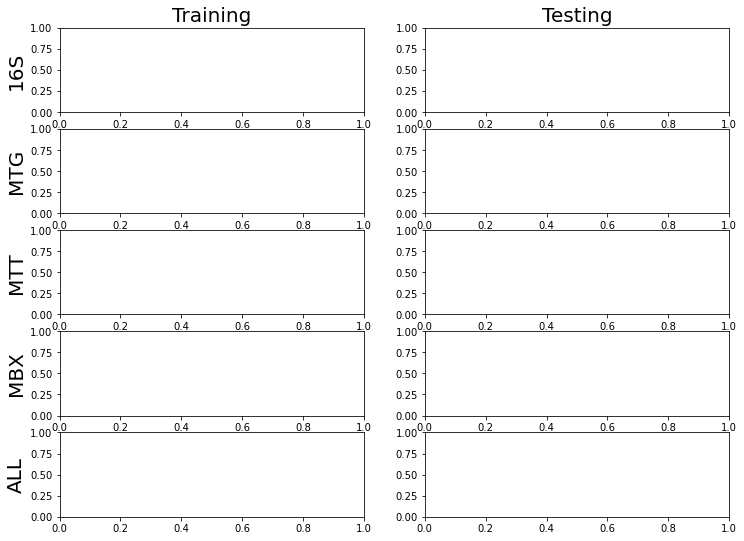

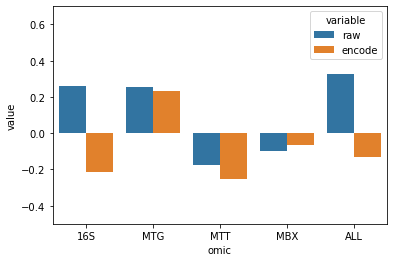

In [145]:
criteria = "fat_oil_freq"
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              criteria, 'rf', transform = transformOrdinal_fruit)
tmp[criteria] = res_raw +  res_encode

In [147]:
tmp

,fruit,dairy,multivitamin,olive_oil,vegetable,probiotic,phenotype,vegetable_freq,fruit_freq,dairy_freq,fat_oil_freq
raw_16S,0.059582,-0.139222,-0.037025,-0.271645,0.210627,0.173814,0.074734,0.478658,0.479894,0.194408,0.260351
raw_MTG,0.193931,0.252115,0.111792,-0.045097,0.231995,0.123768,-0.276810,-0.130460,0.488860,0.455299,0.256787
raw_MTT,0.189310,0.394599,-0.105022,-0.296051,0.305241,-0.302052,0.158164,-0.251291,-0.046797,0.419829,-0.177857
raw_MBX,0.308385,0.456219,0.213220,0.129580,0.354943,0.169920,-0.010085,0.074919,0.168092,0.471534,-0.097637
raw_ALL,0.412790,0.434571,0.034422,0.076430,0.450564,0.038368,-0.073523,-0.261380,0.278548,0.557628,0.326403
16S_MBX,0.428690,0.188591,-0.365147,-0.154286,0.179388,-0.198718,0.182486,0.627776,0.471441,-0.169186,-0.216239
MTG_MBX,0.319231,0.451234,-0.298584,-0.155808,-0.009251,-0.019418,-0.106700,-0.231383,0.548260,0.297189,0.232386
MTT_MBX,0.217044,-0.244857,0.121644,0.059662,-0.384078,-0.088093,-0.001536,-0.569017,-0.266901,-0.139376,-0.251062
MBX_filt,0.373136,0.346068,0.369101,0.232110,0.342016,0.056703,0.132293,-0.172483,0.096424,0.226196,-0.065562
ALL_MBX,0.261517,0.335953,0.195112,0.192899,0.275536,0.013255,0.146685,-0.498039,0.118704,0.231398,-0.131813


In [148]:
tmp.to_csv("performance_between_omics.csv")

# Sqrt then center encoding featuers

In [124]:
%run ml_functions.py
%run functions.py
data_storage = Storage([x_16s, x_mtg, x_mtt, x_mbx, all_omics])
encoded_storage = Storage([encoded_16s, encoded_mtg, encoded_mtt, x_mbx_filt, all_omics_encoded])
data_storage.applyFunction(normalize)
#encoded_storage.applyFunction(np.sqrt)
encoded_storage.applyFunction(normalize)
mapping_storage = Storage([map_16s, map_mtg, map_mtt, map_mtt, map_mtt, map_mtt])
train_bool, test_bool = splitDatasets(x_16s, map_16s, return_bool= True, state = 1)

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

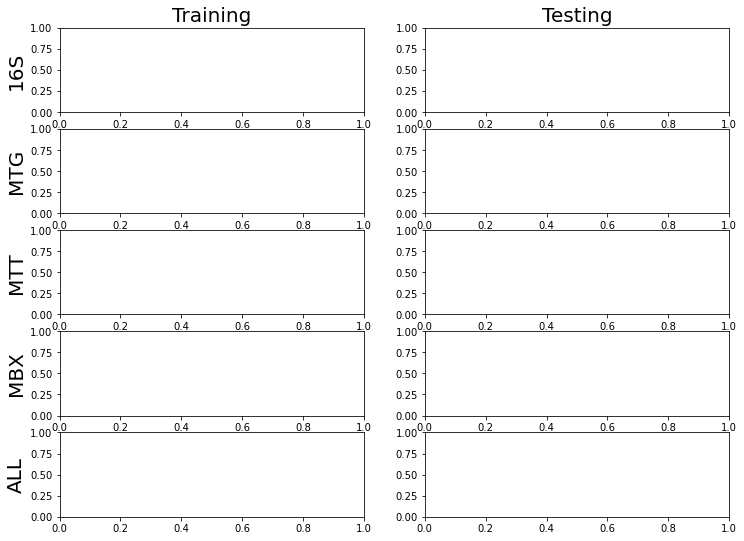

In [125]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              "fruit", 'rf', transformOrdinal_fruit)

In [ ]:

res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              "dairy", 'rf', transform = transformOrdinal_fruit)

In [ ]:

res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'multivitamin', 'rf', transform = None)

In [ ]:

res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'olive_oil', 'rf', transform = transformOrdinal_fruit)

In [ ]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'vegetable', 'rf', transform = transformOrdinal_fruit)

In [ ]:

res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'probiotic', 'rf', transform = transformOrdinal_fruit)

In [ ]:
for i in np.arange(len(mapping_storage.getList())):
    mapping_storage.getList()[i].phenotype = [True if i == 'A' else False for i in mapping_storage.getList()[i].phenotype]
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool, 
                                              'phenotype', 'rf', transform = None)

In [151]:
i = 1
for prev_filt in [.1, .5, .8, 1.0]:
    for metric in ['euclidean', 'bc', 'manhattan', 'horn']:
        for layer in [True, False]:
            print(i)
            print(str(prev_filt) + " " + str(metric) + " " + str(layer))
            i = i + 1

1
0.1 euclidean True
2
0.1 euclidean False
3
0.1 bc True
4
0.1 bc False
5
0.1 manhattan True
6
0.1 manhattan False
7
0.1 horn True
8
0.1 horn False
9
0.5 euclidean True
10
0.5 euclidean False
11
0.5 bc True
12
0.5 bc False
13
0.5 manhattan True
14
0.5 manhattan False
15
0.5 horn True
16
0.5 horn False
17
0.8 euclidean True
18
0.8 euclidean False
19
0.8 bc True
20
0.8 bc False
21
0.8 manhattan True
22
0.8 manhattan False
23
0.8 horn True
24
0.8 horn False
25
1.0 euclidean True
26
1.0 euclidean False
27
1.0 bc True
28
1.0 bc False
29
1.0 manhattan True
30
1.0 manhattan False
31
1.0 horn True
32
1.0 horn False
